In [3]:
import sys

sys.path.append("/pastuer/u/yuhuiz/develop/mmdebug")

import itertools
import json
from pprint import pprint
from typing import List

import clip  # type: ignore
import torch
import torch.nn.functional as F
import numpy as np
from scipy.stats import spearmanr, pearsonr

from datasets import AttributeDataset, ImageDataset, TextDataset, create_dataloader
from models import Linear
from trainer import run_one_epoch
from utils import computing_subgroup_metrics, subgrouping
from matplotlib import pyplot as plt
from utils import openai_imagenet_template, openai_imagenet_classes
from collections import defaultdict


CLIP_MODEL = "ViT-B/32"
LINEAR_MODEL = "fairface_linear_model.pt"
N_CLASS = 2
clip_model, transform = clip.load(name=CLIP_MODEL, device="cuda")
clip_model = clip_model.float()
model = Linear(clip_model.visual.output_dim, N_CLASS).cuda()
state_dict = torch.load(LINEAR_MODEL)
model.load_state_dict(state_dict)

<All keys matched successfully>

# Slice Analysis

## [Preparation] Ground-truth image dataset and text cross-product performance

In [4]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/FairFace/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]


def label_fn(x):
    return 1 if x["attributes"]["gender"] == "Female" else 0


for item in image_data:
    item["label"] = label_fn(item)

image_dataset = ImageDataset(data=image_data)
image_dataloader = create_dataloader(
    dataset=image_dataset, modality="image", transform=transform
)
image_metrics = run_one_epoch(
    dataloader=image_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

# Dataset attributes
attributes = {
    "age": set([x["attributes"]["age"] for x in image_data]),
    "race": set([x["attributes"]["race"] for x in image_data]),
    "gender": set([x["attributes"]["gender"] for x in image_data]),
}
attributes_combinations = [
    dict(zip(attributes, x)) for x in itertools.product(*attributes.values())
]
age_description = {
    "0-2": ["infant boy", "infant girl"],
    "3-9": ["little boy", "little girl"],
    "10-19": ["teenage boy", "teenage girl"],
    "20-29": ["young man", "young woman"],
    "30-39": ["adult man", "adult woman"],
    "40-49": ["middle-aged man", "middle-aged woman"],
    "50-59": ["senior man", "senior woman"],
    "60-69": ["elderly man", "elderly woman"],
    "more than 70": ["very old man", "very old woman"],
}
gender_to_idx = {
    "Male": 0,
    "Female": 1,
}

################################ Raw ################################
# text_data = [
#     {
#         "text": f"{x['age']}, {x['race']}, {x['gender']}.".lower().replace("_", " "),
#         "label": 1 if x["gender"] == "Female" else 0,
#         "attributes": {
#             "age": x["age"],
#             "race": x["race"],
#             "gender": x["gender"]
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Engineering ################################
# text_data = [
#     {
#         "text": f"a face of a {x['race']} {age_description[x['age']][gender_to_idx[x['gender']]]}.".lower().replace("_", " "),
#         "label": 1 if x["gender"] == "Female" else 0,
#         "attributes": {
#             "age": x["age"],
#             "race": x["race"],
#             "gender": x["gender"]
#         },
#     }
#     for x in attributes_combinations
# ]

################################ Prompt Ensemble ################################
text_data = [
    {
        "text": prompt(
            f"face of a {x['race']} {age_description[x['age']][gender_to_idx[x['gender']]]}"
        )
        .lower()
        .replace("_", " "),
        "label": 1 if x["gender"] == "Female" else 0,
        "attributes": {"age": x["age"], "race": x["race"], "gender": x["gender"]},
    }
    for x in attributes_combinations
    for prompt in openai_imagenet_template
]

# TODO: select one from above

text_dataset = TextDataset(data=text_data)
text_dataloader = create_dataloader(dataset=text_dataset, modality="text")
text_metrics = run_one_epoch(
    dataloader=text_dataloader,
    model=model,
    clip_model=clip_model,
    modality="text",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)

Epoch -1, Eval True: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:09<00:00, 33.98it/s]


## Larger slice discovery

In [5]:
fields = ["race"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1]))
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (("race", x["attributes"]["race"]),)
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1]))
print()

[((('race', 'Black'),), 0.8997429305912596),
 ((('race', 'Southeast Asian'),), 0.9342756183745583),
 ((('race', 'East Asian'),), 0.9419354838709677),
 ((('race', 'Indian'),), 0.9445910290237467),
 ((('race', 'Latino_Hispanic'),), 0.9537892791127541),
 ((('race', 'White'),), 0.9597122302158273),
 ((('race', 'Middle Eastern'),), 0.967741935483871)]

[((('race', 'East Asian'),), 0.9916666666666667),
 ((('race', 'Indian'),), 0.99375),
 ((('race', 'Black'),), 0.9958333333333333),
 ((('race', 'White'),), 0.9965277777777778),
 ((('race', 'Southeast Asian'),), 0.9972222222222222),
 ((('race', 'Latino_Hispanic'),), 0.9979166666666667),
 ((('race', 'Middle Eastern'),), 0.9979166666666667)]

[((('race', 'Black'),), 0.9133973119883901),
 ((('race', 'Indian'),), 0.926761427645882),
 ((('race', 'East Asian'),), 0.9277101089350052),
 ((('race', 'Southeast Asian'),), 0.9332894913024372),
 ((('race', 'White'),), 0.9427251905616787),
 ((('race', 'Latino_Hispanic'),), 0.9463455664614836),
 ((('race', 'Mi

## Atomic slice correlation

In [6]:
def compute_correlation(data1_list: List, data2_list: List) -> None:
    assert len(data1_list) == len(data2_list)
    data1 = np.array(data1_list)
    data2 = np.array(data2_list)
    spearmanr_corr, spearmanr_pval = spearmanr(data1, data2)
    pearsonr_corr, pearsonr_pval = pearsonr(data1, data2)
    print(f"Spearman correlation: {spearmanr_corr:.4f} (p-value: {spearmanr_pval:.4f})")
    print(f"Pearson correlation: {pearsonr_corr:.4f} (p-value: {pearsonr_pval:.4f})")
    plt.figure()
    plt.scatter(data1, data2, alpha=0.3, s=10)
    plt.show()

[((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')),
  0.3333333333333333),
 ((('age', '0-2'), ('race', 'Southeast Asian'), ('gender', 'Female')), 0.6),
 ((('age', '3-9'), ('race', 'Black'), ('gender', 'Female')),
  0.6601941747572816)]

[((('age', 'more than 70'), ('race', 'East Asian'), ('gender', 'Male')), 0.95),
 ((('age', 'more than 70'), ('race', 'Indian'), ('gender', 'Male')), 0.95),
 ((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')), 0.975)]

[((('age', '3-9'), ('race', 'Black'), ('gender', 'Female')),
  0.6850505130365491),
 ((('age', '0-2'), ('race', 'Southeast Asian'), ('gender', 'Female')),
  0.7269403524696827),
 ((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')),
  0.7347903911024332)]

Spearman correlation: 0.3548 (p-value: 0.0000)
Pearson correlation: 0.4141 (p-value: 0.0000)


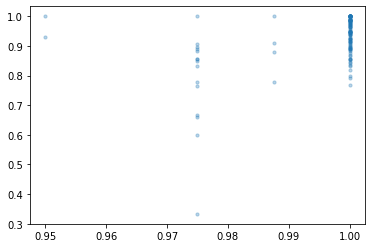

Spearman correlation: 0.5614 (p-value: 0.0000)
Pearson correlation: 0.7227 (p-value: 0.0000)


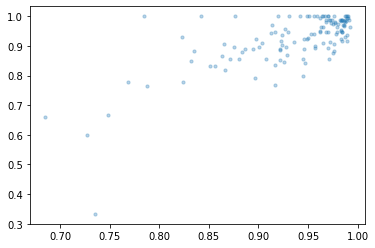

In [7]:
fields = ["age", "race", "gender"]

image_preds, image_labels = image_metrics["preds"], image_metrics["labels"]
image_subgroups = subgrouping(image_data, fields)
image_subgroup_metrics = computing_subgroup_metrics(
    image_preds, image_labels, image_subgroups
)
pprint(sorted(image_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_preds, text_labels = text_metrics["preds"], text_metrics["labels"]
text_subgroups = subgrouping(text_data, fields)
text_subgroup_metrics = computing_subgroup_metrics(
    text_preds, text_labels, text_subgroups
)
pprint(sorted(text_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

text_logits = text_metrics["logits"]
text_probs = torch.softmax(torch.tensor(text_logits), dim=1).numpy().tolist()
text_subgroup_probs = defaultdict(list)
for i, x in enumerate(text_data):
    key = (
        ("age", x["attributes"]["age"]),
        ("race", x["attributes"]["race"]),
        ("gender", x["attributes"]["gender"]),
    )
    value = text_probs[i][x["label"]]
    text_subgroup_probs[key].append(value)
text_subgroup_probs = {k: float(np.mean(v)) for k, v in text_subgroup_probs.items()}
pprint(sorted(text_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [text_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)
compute_correlation(
    [text_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)

## Image Correlation Analysis

Epoch -1, Eval True: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.58it/s]


[((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')), 0.45),
 ((('age', '10-19'), ('race', 'White'), ('gender', 'Female')), 0.65),
 ((('age', '0-2'), ('race', 'Middle Eastern'), ('gender', 'Female')), 0.75)]

[((('age', '0-2'), ('race', 'Black'), ('gender', 'Female')),
  0.4875286865979433),
 ((('age', '0-2'), ('race', 'Middle Eastern'), ('gender', 'Female')),
  0.6417300954461098),
 ((('age', '10-19'), ('race', 'White'), ('gender', 'Female')),
  0.6592520819976926)]

Spearman correlation: 0.3462 (p-value: 0.0001)
Pearson correlation: 0.5447 (p-value: 0.0000)


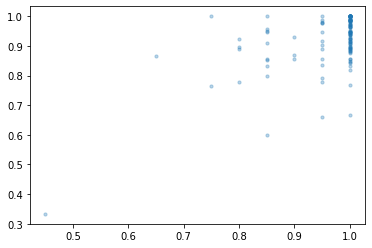

Spearman correlation: 0.4288 (p-value: 0.0000)
Pearson correlation: 0.5411 (p-value: 0.0000)


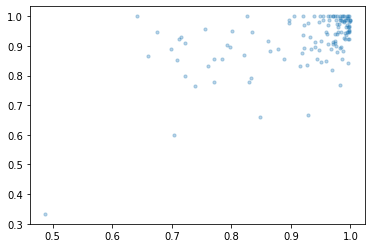

In [11]:
fields = ["age", "race", "gender"]

image_generated_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/mars_develop/fairface/fairface_text_data_generated_images.jsonl"
    )
]

for i, item in enumerate(image_generated_data):
    item["image"] = item["image"].replace("19.png", f"{i % 20}.png")  # bug fix for Mars
    item["image"] = item["image"].replace(
        "/sailhome/marshuang80/mars/", "/pasteur/u/yuhuiz/mars_develop/"
    )
    if item["attributes"]["race"] == "Latino Hispanic":
        item["attributes"]["race"] = "Latino_Hispanic"


def filter_fn(x):
    return True


image_generated_data = [x for x in image_generated_data if filter_fn(x)]


def label_fn(x):
    return 1 if x["attributes"]["gender"] == "Female" else 0


for item in image_generated_data:
    item["label"] = label_fn(item)

image_generated_dataset = ImageDataset(data=image_generated_data)
image_generated_dataloader = create_dataloader(
    dataset=image_generated_dataset, modality="image", transform=transform
)
image_generated_metrics = run_one_epoch(
    dataloader=image_generated_dataloader,
    model=model,
    clip_model=clip_model,
    modality="image",
    opt=None,
    epoch_idx=-1,
    eval=True,
    verbose=True,
)
image_generated_preds, image_generated_labels = (
    image_generated_metrics["preds"],
    image_generated_metrics["labels"],
)
image_generated_subgroups = subgrouping(image_generated_data, fields)
image_generated_subgroup_metrics = computing_subgroup_metrics(
    image_generated_preds, image_generated_labels, image_generated_subgroups
)
pprint(sorted(image_generated_subgroup_metrics.items(), key=lambda x: x[1])[:3])
print()

image_generated_logits = image_generated_metrics["logits"]
image_generated_probs = (
    torch.softmax(torch.tensor(image_generated_logits), dim=1).numpy().tolist()
)
image_generated_subgroup_probs = defaultdict(list)
for i, x in enumerate(image_generated_data):
    key = (
        ("age", x["attributes"]["age"]),
        ("race", x["attributes"]["race"]),
        ("gender", x["attributes"]["gender"]),
    )
    value = image_generated_probs[i][x["label"]]
    image_generated_subgroup_probs[key].append(value)
image_generated_subgroup_probs = {
    # k: v[0] for k, v in image_generated_subgroup_probs.items()
    k: float(np.mean(v))
    for k, v in image_generated_subgroup_probs.items()  # 1 image correlation
}
pprint(sorted(image_generated_subgroup_probs.items(), key=lambda x: x[1])[:3])
print()

compute_correlation(
    [image_generated_subgroup_metrics[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Accuracy-Accuracy Correlation
compute_correlation(
    [image_generated_subgroup_probs[x] for x in image_subgroup_metrics],
    [image_subgroup_metrics[x] for x in image_subgroup_metrics],
)  # Prob-Accuracy Correlation

# Attribute-based Interpretation

In [6]:
image_data = [
    json.loads(line)
    for line in open(
        "/pasteur/u/yuhuiz/data/FairFace/processed_attribute_dataset/attributes.jsonl"
    )
]


def filter_fn(x):
    return x["attributes"]["split"] == "val"


image_data = [x for x in image_data if filter_fn(x)]

age_description = {
    "0-2": "infant",
    "3-9": "little",
    "10-19": "teenage",
    "20-29": "young",
    "30-39": "adult",
    "40-49": "middle-aged",
    "50-59": "senior",
    "60-69": "elderly",
    "more than 70": "very old",
}

attributes = {
    "race": set(
        [x["attributes"]["race"].lower().replace("_", " ") for x in image_data]
    ),
    "age": set([age_description[x["attributes"]["age"]] for x in image_data]),
}

## Direct influence

In [7]:
attribute_list = list(attributes["race"])

attribute_embeddings = F.normalize(
    clip_model.encode_text(clip.tokenize(attribute_list).cuda())
)
probs = torch.softmax(model(attribute_embeddings), dim=1)

attribute_scores = {
    attribute_list[i]: float(probs[i, 1]) for i in range(len(attribute_list))
}

print("If we care about gender (label = female), the most similar attributes are:")
print(sorted(attribute_scores.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about gender (label = female), the most similar attributes are:
[('indian', 0.6278384923934937), ('white', 0.6146937608718872), ('southeast asian', 0.4372418522834778), ('east asian', 0.3901500105857849), ('black', 0.37779057025909424), ('middle eastern', 0.3335767984390259), ('latino hispanic', 0.18446621298789978)]


## Aggregated Influence: Shapley Value s(a) = E_{S subset {F \ a}} [f(S, a) - f(S)]

In [10]:
race_list = list(attributes["race"])
age_list = list(attributes["age"])

attribute_shapley = {}
print(
    "If we care about gender (label = 1 female), the most influential attributes are (reported Shapley value):"
)
for race in race_list:
    prompts = (
        [f"a face of a {age} man." for age in age_list]
        + [f"a face of a {age} woman." for age in age_list]
        + [f"a face of a {race} {age} man." for age in age_list]
        + [f"a face of a {race} {age} woman." for age in age_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(age_list) * 2 :, 1] - probs[: 2 * len(age_list), 1]).mean()
    attribute_shapley[race] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about gender (label = 1 female), the most influential attributes are (reported Shapley value):
[('east asian', tensor(0.0266)),
 ('southeast asian', tensor(0.0119)),
 ('indian', tensor(0.0116)),
 ('latino hispanic', tensor(0.0046)),
 ('white', tensor(0.0040)),
 ('middle eastern', tensor(3.8449e-05)),
 ('black', tensor(-0.0327))]


In [9]:
race_list = list(attributes["race"])
age_list = list(attributes["age"])

attribute_shapley = {}
print(
    "If we care about gender (label = 1 female), the most influential attributes are (reported Shapley value):"
)
for age in age_list:
    prompts = (
        [f"a face of a {race} man." for race in race_list]
        + [f"a face of a {race} woman." for race in race_list]
        + [f"a face of a {race} {age} man." for race in race_list]
        + [f"a face of a {race} {age} woman." for race in race_list]
    )
    with torch.no_grad():
        inputs = clip.tokenize(prompts).cuda()
        embeddings = F.normalize(clip_model.encode_text(inputs))
        probs = torch.softmax(model(embeddings), dim=1).cpu()

    shapley = (probs[len(race_list) * 2 :, 1] - probs[: 2 * len(race_list), 1]).mean()
    attribute_shapley[age] = shapley

pprint(sorted(attribute_shapley.items(), key=lambda x: x[1], reverse=True)[:10])

If we care about gender (label = 1 female), the most influential attributes are (reported Shapley value):
[('very old', tensor(0.0229)),
 ('young', tensor(0.0161)),
 ('senior', tensor(0.0161)),
 ('teenage', tensor(0.0147)),
 ('elderly', tensor(0.0117)),
 ('middle-aged', tensor(0.0079)),
 ('adult', tensor(0.0068)),
 ('little', tensor(-0.0079)),
 ('infant', tensor(-0.0171))]
